# <!-- TITLE --> Unsupervised classification of sound units segmented from soundscapes
---
<!-- DESC --> Machine learning framework to perform unsupervised classification of sound units segmented from soundscapes
<!-- AUTHOR --> : Sylvain Haupert and Juan Ulloa

### Objectives :
 - Providing a script to analyze soundscapes on a GoogleDrive
 - Testing a method to rapidly screen the acoustic content in soundscapes

The goal is to provide a workflow to process soundscapes coming from different recorders set in a tropical rain forest for 24h.

### What we're going to do :

*   Installing Bambird
*   Running Bambird on a dataset
*   Checking the clusters and compare them with a library of sounds produced by expected animals.

### Dataset :

The dataset is a collection of audio recordings from the project XPRIZE (Singapore). Each audio recording lasts 30 min, and they were recorded all day long during the entire May 2022

In this script, you will use the package bambird (more specificaly some functions from bamscape that contains the functions to analyse soundscapes).


## Step 1 - Setup the environment
---

Get the information about the virtual machine that Google gave you

In [1]:
# get info about the virtual machine
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h --si | awk  '/Mem:/{print $2}'

Model name:                         13th Gen Intel(R) Core(TM) i7-13700H
Core(s) per socket:                 14
63G


### 1.1 Global settings

Change or adapt the settings :
- to import the required packages
- to set the directories and the paths
- to set some global constatns
- to set the parameters for bambird

In [4]:
# Load basic packages
# --------------------
import shutil
import numpy as np
from pathlib import Path
import os
import datetime
import yaml
import sys

# scikit-learn (machine learning) package
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# pandas
import pandas as pd

**WARNING** Adapt the paths to your local configuration

In [3]:
# Define constants
# ----------------

# directory where to store the data 
# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PROJECT_PATH    = Path('/media/haupert/data/mes_projets/05_xprize/final')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
# ARCHIVE_PATH    = Path('/media/haupert/data/mes_projets_data/xprize/french_guiana_july_ground')
ARCHIVE_PATH    = Path('/media/haupert/data/mes_projets_data/xprize/canopy_station')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PACKAGE_PATH = Path('/media/haupert/data/mes_projets/_packages/bamscape.git')

DATA_PATH = PROJECT_PATH / Path('DATASETS')
SAVE_PATH = PROJECT_PATH / Path('RESULTS')

# subdirectories where to store the dataset and the extracted rois
DATASET_NAME    = ARCHIVE_PATH.stem + '_all'
ROIS_NAME       = Path(str(DATASET_NAME) +'_ROIS')

# subsample the dataframe containing all the audio recordings
EVERY_N_ROWS = 1 # Set to 1 to keep all files.

# audio file extension
AUDIO_EXTENSION = 'wav'

# Select the configuration file to segment, compute features and get the clusters
CONFIG_FILE     = 'config_soundscape.yaml'


Then, change the settings of bambird. The default settings seems to work well but there are not optimized. Depending on the recorder, the settings of the recorder and the place, they might be adjusted

### 1.1.2 Bambird parameters



In [50]:
#@title settings of bambird { run: "auto", vertical-output: true, form-width: "300px", display-mode: "both" }

###### bambird parameters
# parameters to segment the regions of interest (ROIS)
SAMPLE_RATE= 44100      #@param [8000, 16000, 22000, 24000, 32000, 44100, 48000, 96000, 192000] # in Hz
LOW_FREQ = 50           # in Hz
HIGH_FREQ= 20000        # in Hz
OVLP= 0                 # define the percentage of overlap (0.5 => 50%)
AUDIO_DURATION= 60      # total duration of the file that will be processed in s
CHUNK_DURATION= 10      # the file is then cut in chunk of duration CHUNK_DURATION in s
MODE_RMBCKG = 'median'  #@param ["median", "mean"]                       # select the mode to remove background
N_RUNNING_MEAN= 25      # larger values will keep narrower continuous sound events
NFFT= 1024              #@param [128, 256, 512, 1024, 2048, 4096, 8192]

MAX_RATIO_YX    = 10                # Remove vertical narrow ROIs (mostly rain or noise)
MIN_EVENT_DUR   = 0.025             # Minimum time duration of an event (in s)
MAX_EVENT_DUR   = AUDIO_DURATION    # Maximum time duration of an event (in s)
MIN_FREQ_BW     = 50               # Minimum frequency bandwidth (in Hz). Could be a list of 2 elements (the min min and the max min)
MAX_FREQ_BW     = 8000              # Maximum frequency bandwidth (in Hz). Could be a list of 2 elements (the max min and the max max)
FUSION_ROIS     = (0.05, 100)       # (seconds, hertz) 
REMOVE_ROIS_FMIN_LIM = 50
REMOVE_ROIS_FMAX_LIM = None
REMOVE_RAIN     = True

SEED_LEVEL  = 13        # in dB (select the seeds to create the mask to segment the ROIs)
LOW_LEVEL   = 6         # in dB (select the lowest value that will be part of the mask to segment the ROIs)

# Save ROIs parameters
MARGIN_T= 0.05           #@param {type:"number"}  # time margin in s around the ROI
MARGIN_F= 100               #@param {type:"number"}  # frequency margin in Hz around the ROI
FILTER_ORDER= 5         #@param {type:"number"}  # butterworth filter order to select the bandwidth corresponding to the ROI

# parameters to cluster  the ROIs
# UMAP parameters
N_COMPONENTS= 10        # The dimension of the space to embed into. Should not be larger than 20 as (H)DBSCAN cannot handle vectors larger than 20 points.
N_NEIGHBORS= 30         # The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation. 
                        # Larger values result in more global views of the manifold, while smaller values result in more local data being preserved
MIN_DIST= 0             # The effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding 
                        # where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points
N_AVG_UMAP= 1           # Number of UMAP that will be averaged. 
# (H)DBSCAN parameters
METHOD= 'HDBSCAN'       #@param ["DBSCAN", "HDBSCAN"]                   # clustering methods
MIN_PTS= 5              #@param {type:"number"}                         # min number of points to form a cluster
MIN_CORE_PTS= 10*2-1  
EPS= 'auto'             #@param {type:"raw"}                           # 'auto' or a value between 0 to 2 , usually between 0.05 and 0.15

# select the features that will be used to perform the clustering
shp = True              #@param {type:"boolean"}
centroid_f = True       #@param {type:"boolean"}
peak_f = True           #@param {type:"boolean"}
duration_t = False      #@param {type:"boolean"}
bandwidth_f = False     #@param {type:"boolean"}
min_f = False           #@param {type:"boolean"}
max_f = False           #@param {type:"boolean"}

FEATURES = []
if shp : FEATURES.append('shp')
if centroid_f : FEATURES.append('centroid_f')
if peak_f : FEATURES.append('peak_f')
if duration_t : FEATURES.append('duration_t')
if bandwidth_f : FEATURES.append('bandwidth_f')
if min_f : FEATURES.append('min_f')
if max_f : FEATURES.append('max_f')

### other global parameters

In [37]:
# select the ROIs with SNR higher than SNR_HLIM
SNR_HLIM = 16           #@param {type:"slider", min:0, max:90, step:1}

# select the ROIs with centroid frequency between CENTROID_FREQ_LLIM and CENTROID_FREQ_HLIM (in Hz)
CENTROID_FREQ_HLIM = 20000 
CENTROID_FREQ_LLIM = 0

# Define the margins in time and frequency for the ROIs that will be sent
# to the experts
ROIS_NAME_EXPERT = Path(str(ROIS_NAME) + '_EXPERT')
MARGIN_T_EXPERT = 0.250 # 250 ms => 0.5s min
MARGIN_F_EXPERT = 500 # 0.5kHz   => 1kHz min

### 1.1.2 Define some local functions

In [38]:
# %%
def date_from_filename (filename) :
    # filename with format 'XXXX_yyyymmdd_hhmmss.wav'
    # extract year, month, day, hour, minute and second from the filename
    # notice the underscore _ which splits the filename into several parts
    year = int(filename.split('_')[1][0:4])
    month = int(filename.split('_')[1][4:6])
    day = int(filename.split('_')[1][6:8])
    hour = int(filename.split('_')[2][0:2])
    minute = int(filename.split('_')[2][2:4])
    #second = int(filename.split('_')[2][4:6])
    second = 00

    # create a datetime object from the extracted parameters
    date = datetime.datetime(year, month, day, hour, minute, second)

    return date

# %%
def find_representative_samples (df_cluster):
            
    # copy
    df = df_cluster.copy()

    # set cluster_number as the index
    # df.set_index("cluster_number", inplace = True)

    # compute the average shapes for each filename
    df['features'] = df['features'].apply(lambda x: np.array(x))
    
    df_avg = pd.DataFrame({'features' : df.groupby('cluster_number')['features'].apply(np.mean)})
    
    # dataframe with the nearest samples to the center of each cluster
    df['dist_likeness'] = np.nan
    df['normdist'] = np.nan
    df['dist'] = np.nan
    df['cosine_likeness'] = np.nan
    df['cosine'] = np.nan
    df['model'] = 0
    
    
    for index, y in df_avg.iterrows():  

        # if noise, continue
        if index == -1 :
            continue
        
        # variables
        y = y.features 
        X = np.array(df[df.cluster_number == index].features.tolist())

        # distance
        neighbors = NearestNeighbors(n_neighbors=len(X))
        neighbors_fit = neighbors.fit(X)
        distances, index_sample = neighbors_fit.kneighbors([y])       
        d = distances[0]
        # angle
        a = cosine_similarity(X, y.reshape(1,-1)).flatten()
        
        # Give an indicator of the likeness of the sample regarding its cluster
        #-------------------------------------------------------------------------
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the distance between /REC4_20210527_2335_10s_04.wav /REC4_20210527_2340_0s_08.wav /REC4_20210527_2340_0s_10.wav /REC4_20210527_2340_0s_12.wav /REC4_20210527_2340_0s_14.wav /REC4_20210527_2340_30s_03.wav /REC4_20210527_2340_30s_05.wav /REC4_20210527_2340_30s_07.wav /REC4_20210527_2340_30s_08.wav /REC4_20210527_2340_30s_12.wav /REC4_20210527_2340_30s_13.wav /REC4_20210527_2340_30s_14.wav /REC4_20210527_2340_30s_15.wav /REC4_20210527_2340_30s_17.wav /REC4_20210527_2340_30s_18.wav /REC4_20210527_2340_40s_06.wav /REC4_20210527_2340_40s_11.wav /REC4_20210527_2340_50s_06.wav /REC4_20210527_2355_10s_07.wav /REC4_20210528_0950_30s_04.wavthe furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'dist_likeness': 1-(d-min(d))/(max(d)-min(d))},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # normalized distance
        # 1 is the closest to the model 
        # 2 is twice the distance to the model
        # 10 is ten times the minimum distance to the model
        df.update(pd.DataFrame({'normdist': d/d[0]},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # absolute distance
        d = distances[0]
        df.update(pd.DataFrame({'dist': d},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # similarity (cosine)
        # 1 both vectors are colinear (the angle is 0°)
        # 0 both vectors are orthogonal (the angle is 90°)
        df.update(pd.DataFrame({'cosine': a},
                                index =  df[df.cluster_number == index].index ))
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the angle between the furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'cosine_likeness': (a-min(a))/(max(a)-min(a))},
                                index =  df[df.cluster_number == index].index ))

        # df_cluster_per_file['features'] = df_cluster_per_file['features'].apply(lambda x: np.array(x))
        # # Compute the silhouette scores for each sample
        # X = np.array(df_cluster_per_file.features.tolist())
        # silhouette = silhouette_samples(X, df_cluster_per_file['cluster_number'])
        # df_cluster_per_file['silhouette'] = silhouette


        # add a column "model"
        # 1 => the closest to the average features = model, 0 either.        
        idx = df[df.cluster_number == index].iloc[index_sample[0][0]].name
        df.at[idx,'model'] = 1

    return df

# %%
def select_cluster_percentile (
                            df_cluster,
                            column      = "cluster_number",
                            percentile  = 75,
                            remove_noise= True
                            ) :
    # Count the number of ROIs per cluster and select the first "percentile" of
    # cluster, from the biggest (percentile = 1) to the smallest (percentile = 99)
    # Does not take into account the cluster "noise" (=-1)

    # copy the dataframe
    df = df_cluster.copy()

    # clean df_cluster by removing the noise : -1
    if remove_noise :
        df = df[df[column] >-1]

    # count the number of each value
    counts = df[column].value_counts()

    # sort counts value from the highest count to the lowest
    counts = counts.sort_values(ascending=False)

    # select the vector of id
    cumulative = counts.cumsum() / counts.sum()
    mask = cumulative > (percentile / 100)
    idx = cumulative[mask].index[0]
    selected = counts.loc[:idx]

    # filter the dataframe to keep only the biggest clusters
    df = df[df[column].isin(selected.index)]

    return df

## Step 2 - Data processing
---

Load the configuration file. In case of soundscapes, the file ***config_soundscape.yaml*** works well for most soundscapes. Of course you can also edit the file and adapt the parameters to your need.

## 2.1 Import and configuration

In [39]:
# import the custom packages
#----------------------------
import maad
import bambird

In [51]:
# Load the configuration file
# -----------------------------
params = bambird.load_config(PACKAGE_PATH / "src/bambird" / CONFIG_FILE)

# change some parameters
params['PARAMS_EXTRACT']['SAMPLE_RATE'] = SAMPLE_RATE
params['PARAMS_EXTRACT']['HIGH_FREQ'] = HIGH_FREQ
params['PARAMS_EXTRACT']['LOW_FREQ'] = LOW_FREQ
params['PARAMS_EXTRACT']['OVLP'] = OVLP
params['PARAMS_EXTRACT']['AUDIO_DURATION'] = AUDIO_DURATION
params['PARAMS_EXTRACT']['CHUNK_DURATION'] = CHUNK_DURATION

params['PARAMS_EXTRACT']['MODE_RMBCKG'] = MODE_RMBCKG
params['PARAMS_EXTRACT']['N_RUNNING_MEAN'] = N_RUNNING_MEAN
params['PARAMS_EXTRACT']['NFFT'] = NFFT

params['PARAMS_EXTRACT']['MAX_RATIO_YX'] = MAX_RATIO_YX
params['PARAMS_EXTRACT']['MIN_EVENT_DUR'] = MIN_EVENT_DUR
params['PARAMS_EXTRACT']['MAX_EVENT_DUR'] = MAX_EVENT_DUR
params['PARAMS_EXTRACT']['MIN_FREQ_BW'] = MIN_FREQ_BW
params['PARAMS_EXTRACT']['MAX_FREQ_BW'] = MAX_FREQ_BW
params['PARAMS_EXTRACT']['REMOVE_ROIS_FMIN_LIM'] = REMOVE_ROIS_FMIN_LIM
params['PARAMS_EXTRACT']['REMOVE_ROIS_FMAX_LIM'] = REMOVE_ROIS_FMAX_LIM
params['PARAMS_EXTRACT']['FUSION_ROIS'] = FUSION_ROIS
params['PARAMS_EXTRACT']['REMOVE_RAIN'] = REMOVE_RAIN

params['PARAMS_EXTRACT']['SEED_LEVEL'] = SEED_LEVEL
params['PARAMS_EXTRACT']['LOW_LEVEL'] = LOW_LEVEL

params['PARAMS_EXTRACT']['MARGIN_T'] = MARGIN_T
params['PARAMS_EXTRACT']['MARGIN_F'] = MARGIN_F

params['PARAMS_FEATURES']['SAMPLE_RATE'] = SAMPLE_RATE
params['PARAMS_FEATURES']['HIGH_FREQ'] = HIGH_FREQ
params['PARAMS_FEATURES']['LOW_FREQ'] = LOW_FREQ

params['PARAMS_CLUSTER']['N_COMPONENTS'] = N_COMPONENTS
params['PARAMS_CLUSTER']['N_NEIGHBORS'] = N_NEIGHBORS
params['PARAMS_CLUSTER']['MIN_DIST'] = MIN_DIST
params['PARAMS_CLUSTER']['N_AVG_UMAP'] = N_AVG_UMAP

params['PARAMS_CLUSTER']['METHOD'] = METHOD
params['PARAMS_CLUSTER']['MIN_PTS'] = MIN_PTS
params['PARAMS_CLUSTER']['MIN_CORE_PTS'] = MIN_CORE_PTS
params['PARAMS_CLUSTER']['FEATURES'] = FEATURES
params['PARAMS_CLUSTER']['EPS'] = EPS

use the function <bambird.extract_rois_in_soundscape> to segment ROIS


## 2.2 Grab and prepare audio

In [41]:
# Grab audio
# -------------------
df = bambird.grab_audio_to_df(ARCHIVE_PATH, AUDIO_EXTENSION)

# grab all audio recording files in the dataset
#filelist = glob(ARCHIVE_PATH+'/**/*'+'.'+AUDIO_EXTENSION, recursive = True)

# create a column date
df['date'] = df.filename.apply(date_from_filename)

# print the number of audio recordings
print("The number of audio recordings is %d" %len(df))

The number of audio recordings is 216


**Subsamples the dataframe** in order to make quick tests

In [42]:
# Keep rows every N rows
df = df.iloc[::EVERY_N_ROWS, :]

# print the number of audio recordings
print("The number of audio recordings that will be processed is %d" %len(df))

The number of audio recordings that will be processed is 216


## 2.3 Extract ROIS



*   First extract ROIS of a single file in order to see if the parameters are fine.
*   Display the SNR for each ROIS found in the audio file





CATEGORIES : french_guiana_july_ground
NUMBER OF CHUNKS : 6

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.656510231107596dB / SNR 1.5665251380306273dB
BEFORE MERGING FOUND 32 ROIS 
=> AFTER MERGING FOUND 26 ROIS
=> number of ROIS after ploting 26
=> number of ROIS after ploting 26

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.656277978663482dB / SNR 0.8114540006360471dB
BEFORE MERGING FOUND 22 ROIS 
=> AFTER MERGING FOUND 15 ROIS
=> number of ROIS after ploting 15
=> number of ROIS after ploting 15

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.656449429545532dB / SNR 1.3182787143249897dB
BEFORE MERGING FOUND 32 ROIS 
=> AFTER MERGING FOUND 30 ROIS
=> number of ROIS after ploting 30
=> number of ROIS after ploting 30

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.656442051446874dB / SNR 1.4729709104991784dB
BEFORE MERGING FOUND 42 ROIS 
=> AFTER MERGING

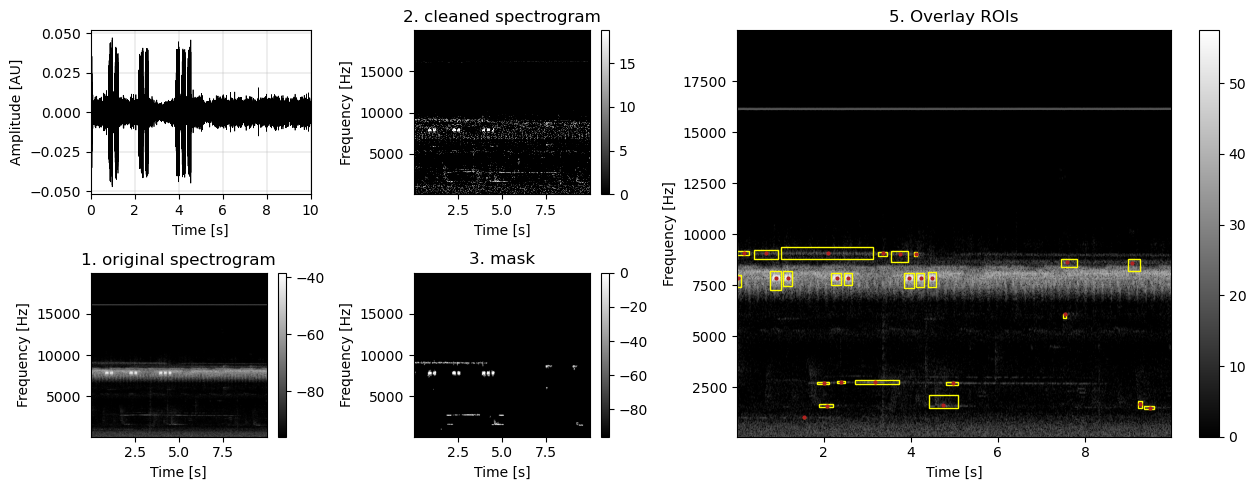

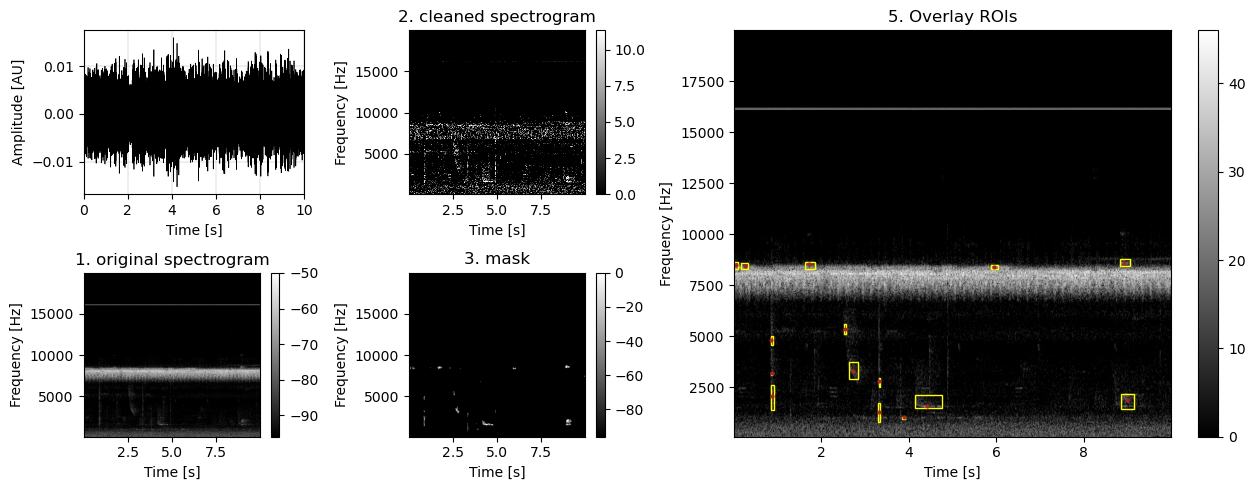

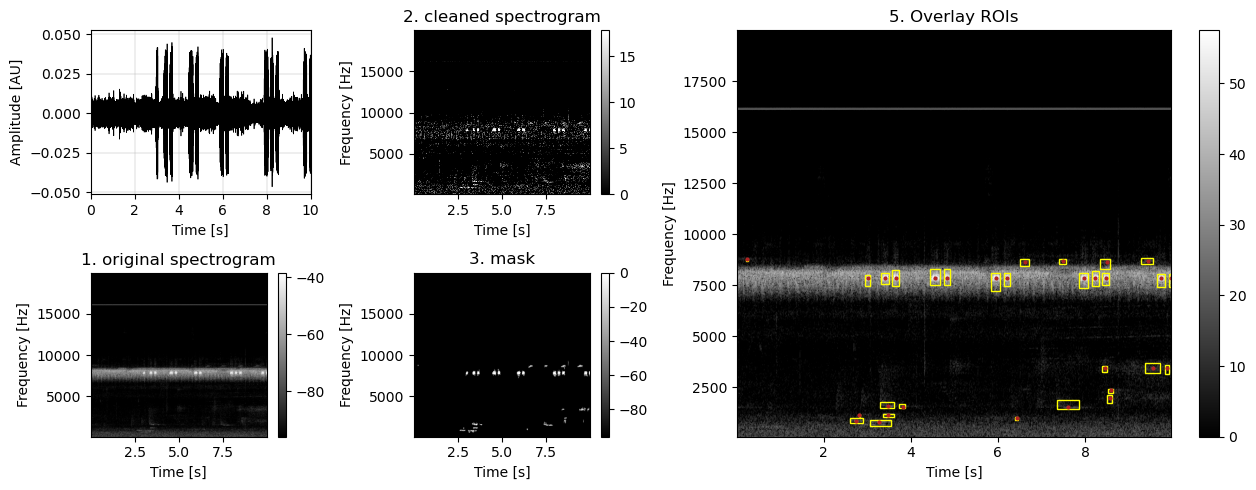

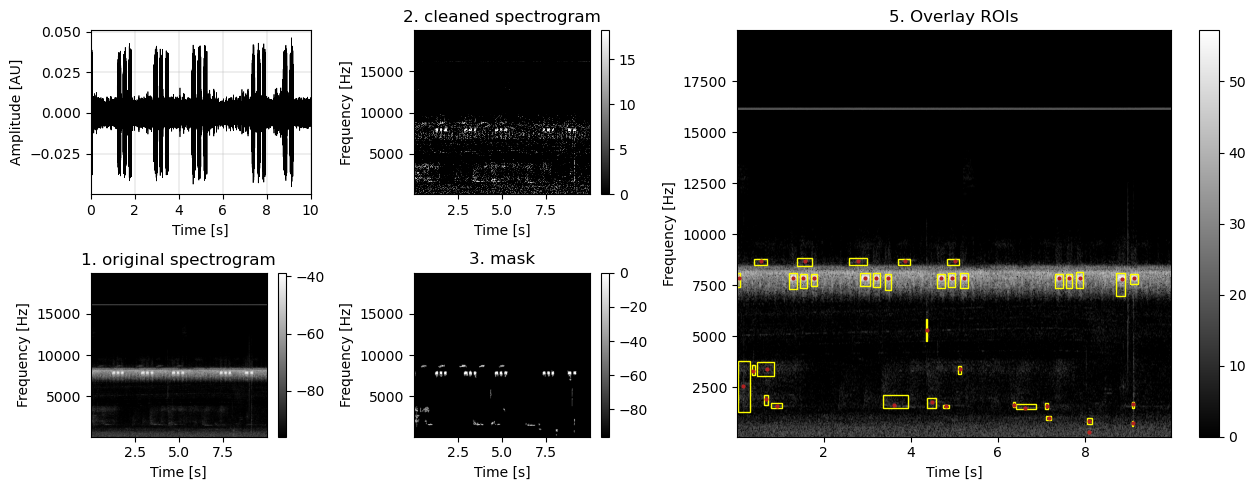

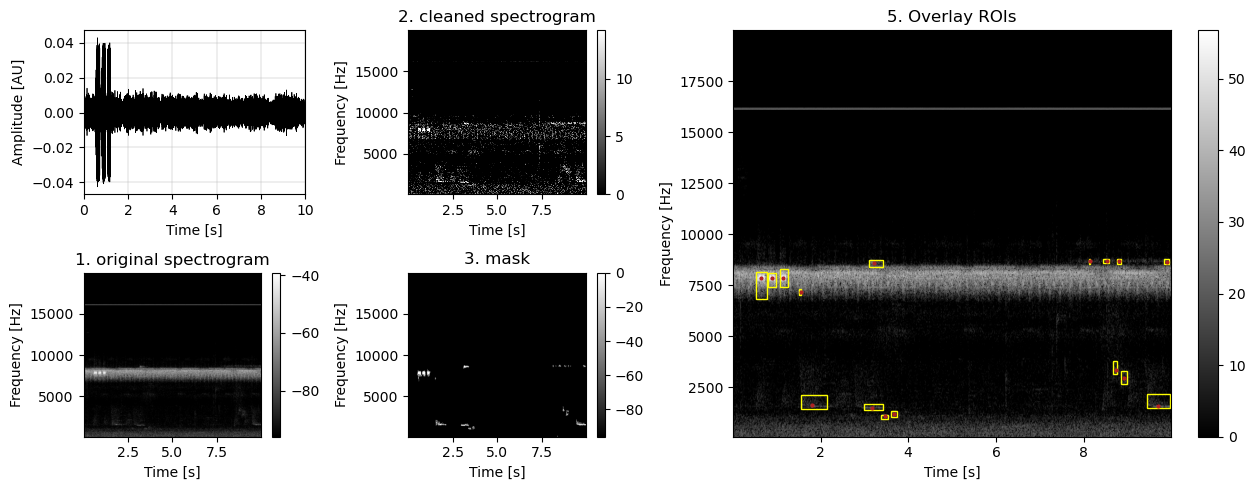

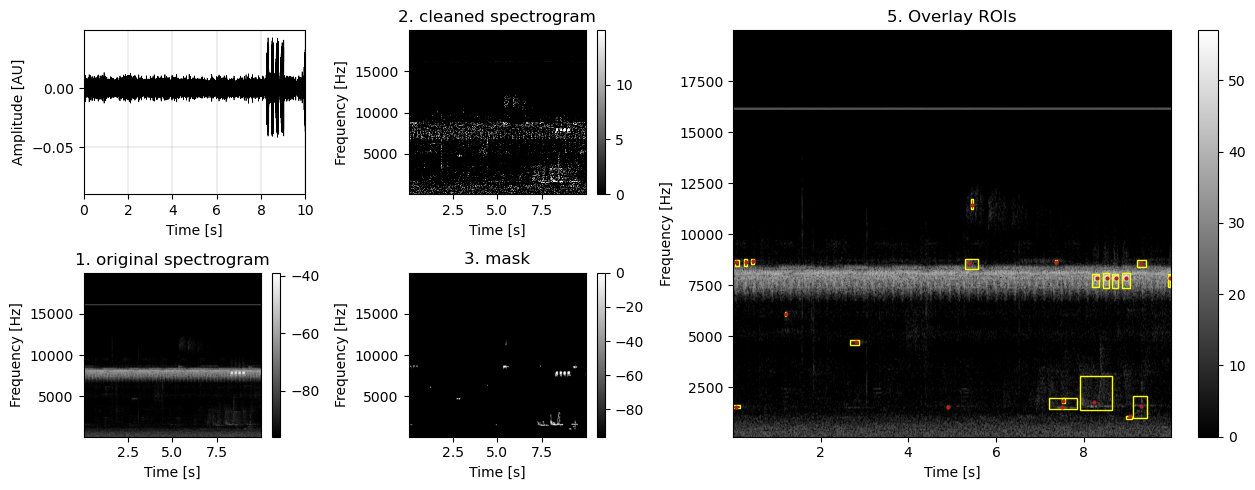

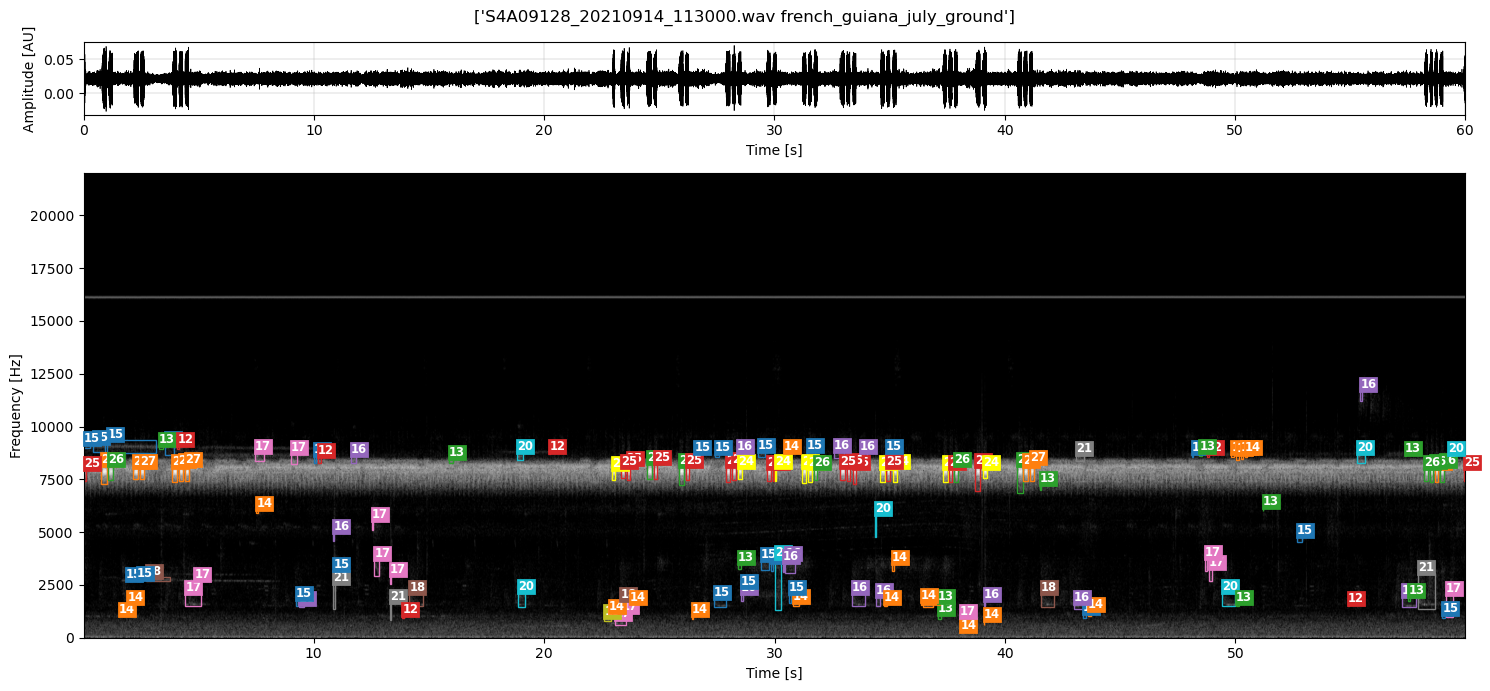

In [11]:
# Extract ROIS of a single file
# -------------------------------

# ROIS extraction of a single file
df_rois_single = bambird.single_file_extract_rois (
                    audio_path  = df.sample().fullfilename.squeeze(),
                    # audio_path  = ARCHIVE_PATH/'MAGNETO_02_S4A03544/S4A03544_20190627_044500.wav',  # if a specific file needs to be tested 
                    # audio_path  = ARCHIVE_PATH/'MAGNETO_03_S4A03536/S4A03536_20190624_133000.wav',  # if a specific file needs to be tested
                    # audio_path  = ARCHIVE_PATH/'S4A09154_20210124_201500.wav',  # if a specific file needs to be tested
                    # audio_path  = ARCHIVE_PATH/'SMA04687_20230402_080002.wav',
                    fun         = params['PARAMS_EXTRACT']['FUNC'],
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    display     = True,
                    verbose     = True)

# and display the ROIs on the file
# convert the column snr into integer in order to use the value as a label for each ROI
# This is temporary, only on df_rois_single that will not be used after
if len(df_rois_single) > 0 : # test if there is at least a single ROI
  df_rois_single["snr"] = df_rois_single["snr"].apply(int)
  bambird.overlay_rois(
                      cluster         = df_rois_single,
                      params          = params['PARAMS_EXTRACT'],
                      column_labels   = 'snr', 
                      unique_labels   = np.sort(df_rois_single.snr.unique()),
                      filename        = None,
                      random_seed     = None,
                      verbose         = True
                      )
else :
  print("No ROI was found")

Extract all the ROIS. It takes about an hour for 300 1 min audio files

In [43]:
# Extract ROIS
# -------------------------------

# ROIS extraction of the full dataset
df_rois, csv_rois = bambird.multicpu_extract_rois(
                    dataset     = df,
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    overwrite   = True,
                    verbose     = True
                    )

print("{} rois were found".format(len(df_rois)))

======================= EXTRACT ROIS =========================

The directory /media/haupert/data/mes_projets/05_xprize/final/DATASETS/french_guiana_july_ground_all_ROIS already exists and will be overwritten
No audio file needs to be segmented
>>> EXTRACTION PROCESS ABORTED <<<
72860 rois were found


Extract all the ROIs for Experts (with large margins in time and frequency around the ROI)

In [44]:
# Extract ROIS for experts
# -------------------------------

params['PARAMS_EXTRACT']['MARGIN_T'] = MARGIN_T_EXPERT # 750 ms => 1.5s min
params['PARAMS_EXTRACT']['MARGIN_F'] = MARGIN_F_EXPERT # 1kHz   => 2kHz min

# ROIS extraction of the full dataset
df_rois_expert, csv_rois_expert = bambird.multicpu_extract_rois(
                    dataset     = df,
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME_EXPERT,
                    overwrite   = True,
                    verbose     = True
                    )

print("{} rois were found".format(len(df_rois)))

======================= EXTRACT ROIS =========================

The directory /media/haupert/data/mes_projets/05_xprize/final/DATASETS/french_guiana_july_ground_all_ROIS_EXPERT already exists and will be overwritten
No audio file needs to be segmented
>>> EXTRACTION PROCESS ABORTED <<<
72860 rois were found


## 2.4 Compute features
It takes about an hour for about 20 000 ROIs

In [45]:
# Compute features for each ROIS
# -------------------------------

# compute the features on the full dataset
df_features, csv_features = bambird.multicpu_compute_features(
                dataset     = df_rois,
                params      = params['PARAMS_FEATURES'],
                save_path   = DATA_PATH / ROIS_NAME,
                overwrite   = True,
                verbose     = True)




====================== COMPUTE FEATURES ======================

No feature needs to be computed
>>> FEATURES COMPUTING PROCESS ABORTED <<<


# Step 3 - Clustering and display

* First, you can select only ROIs with SNR higher than a threshold. This will help to cluster only the "best" sound events
* Secondly, you can select ROIs with frequency centroid between low and high limits in order to focus on avian (200Hz-8000Hz), amphibians (0Hz-5000Hz), insects (>4000Hz)...

In [46]:
# Select ROIS with high SNR
#--------------------------------
df_features_selected = df_features[df_features.snr >= SNR_HLIM]
print("Keep {} ROIs with SNR >= {}dB over {}".format(len(df_features_selected), SNR_HLIM, len(df_features)))

Keep 39373 ROIs with SNR >= 16dB over 72860


In [47]:
# Select ROIS depending on the centroid frequency
#-------------------------------------------------
df_features_selected = df_features_selected[(df_features_selected.centroid_f <= CENTROID_FREQ_HLIM) & (df_features_selected.centroid_f >= CENTROID_FREQ_LLIM)]
print("Keep {} ROIs with centroid frequency between {}Hz and {}Hz".format(len(df_features_selected), CENTROID_FREQ_LLIM, CENTROID_FREQ_HLIM))


Keep 39373 ROIs with centroid frequency between 0Hz and 20000Hz


In [52]:
#  Cluster ROIS
# -------------------------------

# find the clusters by categories
df_cluster, csv_cluster = bambird.find_cluster(
                dataset = df_features_selected,
                params  = params['PARAMS_CLUSTER'],
                display = False,
                verbose = True
                )



====================== CLUSTER FEATURES ======================

HDBSCAN eps 0.06276633562874336 min_samples 5 min_cluster_size 19 Number of soundtypes found for french_guiana_july_ground : 395




============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/french_guiana_july_ground/S4A09154_20210123_210000.wav
labels : [162 205  -1 209 209 317  -1  -1  13  87   8   7 127 209  87  88  -1  88
  88 209  88 101 100 100  -1  92 210 103 103 103 103  70  65 168 157  -1
 211 389  -1 188   4   4   4   4   4   4  -1  -1 291 225  -1  -1 348  -1
 254 254  -1 277  -1 284  -1  -1  -1 284  -1  -1  -1  88 101 101 101 209
  -1 104 103  -1 103  -1 103  -1 103 103 103 103 103  -1 209 209  -1  64
  64  64 209 209  -1  -1   4   4   4 377 377   4   4  -1  -1 225 191 191
 258 323 311  -1 280 280 280  -1  -1 275 317  -1 180 180 180 373 373 209
  -1  -1 209 295  -1  -1  87  87  -1   8  88 101  -1  -1 100 104 100  -1
  -1 104  -1 103 103  -1  -1 103 103  -1  -1  -1 103 103  99 103  -1 102
  65  64  64  64  64  64  64  64  64 188   4   4   4   4   4   4  -1  -1
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4

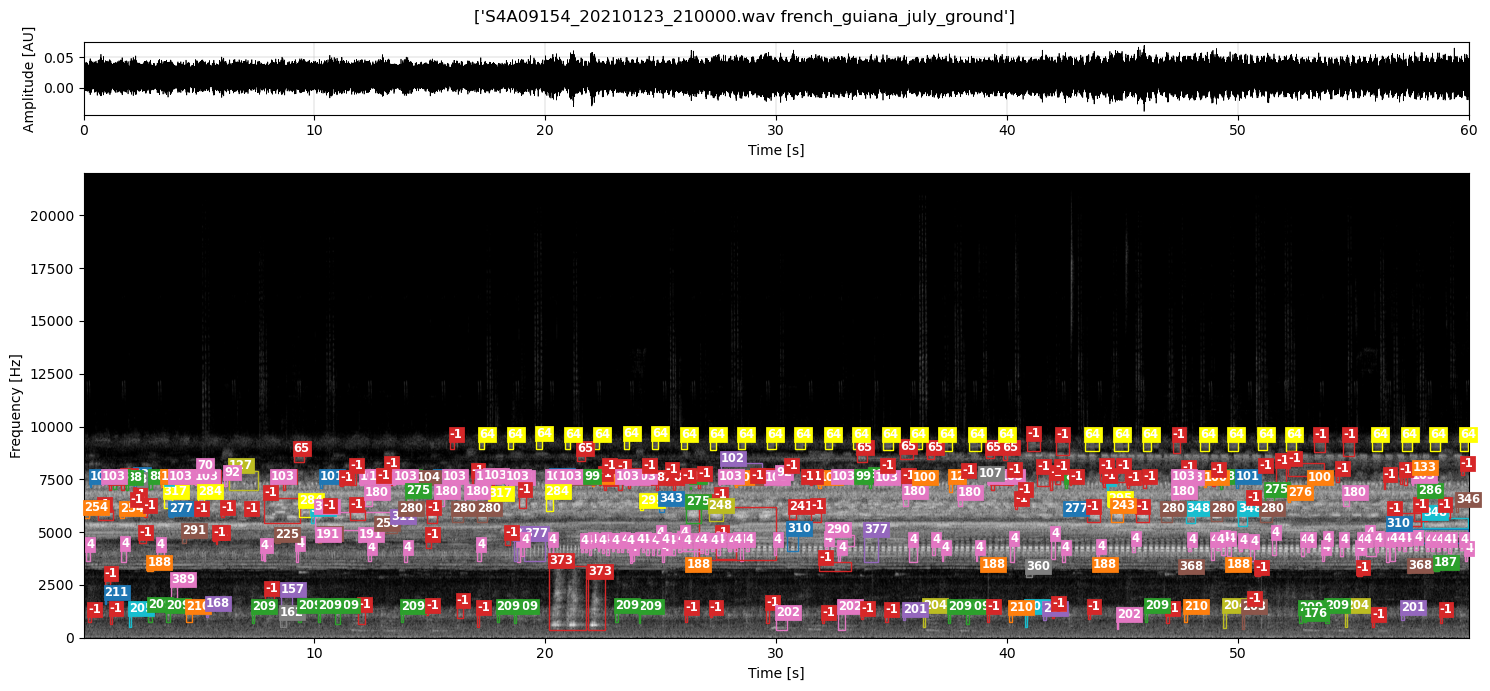

'S4A09154_20210123_210000.wav'

In [55]:
# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_cluster,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_cluster.cluster_number.unique()),
                    filename        = None,
                    # filename        = 'S4A09128_20210917_103000.wav', # S4A09128_20211011_033000 S4A09128_20211008_064500 S4A09128_20210211_043000 S4A09128_20211026_044500 S4A09128_20210603_074500 S4A09128_20210917_103000
                    random_seed     = None,
                    verbose         = True
                    )

In [56]:
# Reorder the dataframe by cluster_number starting by the biggest size
# --------------------------------------------------------------------

# count the number of each cluster_number
counts = df_cluster["cluster_number"].value_counts()

# sort counts value from the highest count to the lowest
counts = counts.sort_values(ascending=False)

# map the count to the cluster_number
df_cluster['count'] = df_cluster['cluster_number'].apply(lambda x: counts.get(x, -1))

# Reorder the dataframe starting the highest number of clusters 
df_cluster.sort_values(by='count', ascending=False, inplace=True)

# Get the cluster numbers in ascending order (without the noise -1)
CLUSTER_NUM_ASC_ORDER = list(df_cluster.loc[~(df_cluster['cluster_number']==-1),:]['cluster_number'].value_counts().index)

print("List of the cluster number from the biggest cluster to the smallest cluster : {}".format(list(CLUSTER_NUM_ASC_ORDER)))



List of the cluster number from the biggest cluster to the smallest cluster : [4, 211, 328, 264, 291, 111, 284, 362, 295, 112, 59, 252, 55, 202, 348, 174, 131, 157, 13, 92, 369, 248, 217, 216, 65, 368, 17, 159, 376, 275, 334, 310, 311, 30, 225, 118, 383, 20, 145, 73, 230, 285, 37, 190, 312, 64, 70, 5, 133, 302, 204, 322, 260, 300, 235, 333, 63, 113, 43, 325, 340, 88, 26, 31, 12, 127, 213, 188, 374, 197, 193, 82, 365, 391, 258, 313, 390, 33, 326, 45, 343, 34, 187, 15, 278, 226, 134, 28, 126, 25, 298, 379, 363, 194, 0, 360, 393, 290, 254, 353, 349, 382, 40, 355, 274, 263, 67, 77, 228, 146, 280, 42, 107, 315, 54, 46, 332, 115, 117, 247, 72, 371, 29, 361, 156, 224, 41, 221, 164, 389, 200, 372, 358, 243, 241, 18, 21, 83, 103, 199, 255, 6, 175, 38, 150, 336, 262, 370, 330, 392, 277, 249, 299, 210, 238, 170, 366, 231, 205, 282, 98, 250, 292, 276, 24, 140, 381, 289, 11, 357, 207, 309, 141, 148, 356, 149, 165, 7, 114, 195, 223, 57, 345, 342, 354, 105, 23, 109, 364, 305, 78, 35, 9, 321, 257, 125

In [57]:
# Select the most important clusters
# ------------------------------------

#df_cluster_selected = select_cluster_percentile(df_cluster, percentile = 90)

#print("We select {} clusters over {} which regroup 90% of the rois" .format(len(df_cluster_selected['cluster_number'].value_counts().index), len(df_cluster['cluster_number'].value_counts().index)))

Compute different metrics (cosine_likeness dist_likeness normdist) to estimate the likeness or the distance to the "centroid" of a cluster (= features of all ROIs that belongs to a cluster are averaged)

In [58]:
# find representative samples and save dataframe
#-------------------------------------
df_cluster_repsamples = find_representative_samples(df_cluster)


In [59]:
NUM_SAMPLES_BY_CLUSTER = 20
METRIC = 'dist_likeness' # cosine_likeness dist_likeness normdist

# Group the dataframe by category and get the top 20 rows per category based on lowest normdist. Remove noise cluster (-1)
cols = ['cluster_number', 'count', 'filename_ts',  'fullfilename_ts', 'fullfilename','filename', 'min_t', 'max_t', 'min_f', 'max_f', METRIC]
df_cluster_selected = df_cluster_repsamples[cols].groupby('cluster_number').apply(lambda x: x.nsmallest(NUM_SAMPLES_BY_CLUSTER, METRIC) if len(x) >= NUM_SAMPLES_BY_CLUSTER else x)
df_cluster_selected = df_cluster_selected.loc[~ (df_cluster_selected.cluster_number==-1),:]
df_cluster_selected['group (insect, bird, bat, frog, noise, unknown)'] = ''
df_cluster_selected['scientific_name'] = ''
df_cluster_selected['english_name'] = ''

# save
filename = str(DATASET_NAME) + '_CLUSTERS.csv'
# test if the directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
df_cluster_selected.to_csv(SAVE_PATH / filename, index=False)

In [61]:
# Save the most representative ROIS of each cluster in folders
for index, row in df_cluster_selected.iterrows():
    # get the cluster number
    cluster_number = row.cluster_number
    # create the path
    folder = Path(str(DATASET_NAME) +  ('_CLUSTERS')) 
    # create the folders and subfolders
    try:
        os.makedirs(SAVE_PATH / folder / str(cluster_number))
    except FileExistsError:
        # directory already exists
        print("directory {} already exists".format(SAVE_PATH / folder / str(cluster_number)))
        pass
    # copy paste the file in the right directory 
    try : 
        src = DATA_PATH / ROIS_NAME_EXPERT  / Path(row.fullfilename).parts[-2] /row.filename_ts
        dst = SAVE_PATH / folder / str(cluster_number) / row.filename_ts
        shutil.copy2(src,dst)
    except  :
        # directory already exists
        print("file {} does not exist".format(DATA_PATH / ROIS_NAME_EXPERT))
        df_cluster_selected.drop(index=index, inplace=True)
        pass

directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert/data/mes_projets/05_xprize/final/RESULTS/french_guiana_july_ground_all_CLUSTERS/0 already exists
directory /media/haupert

Select the metric and then display the most representative ROI of the cluster and then the random ROIs that are below or upper of a threshold

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


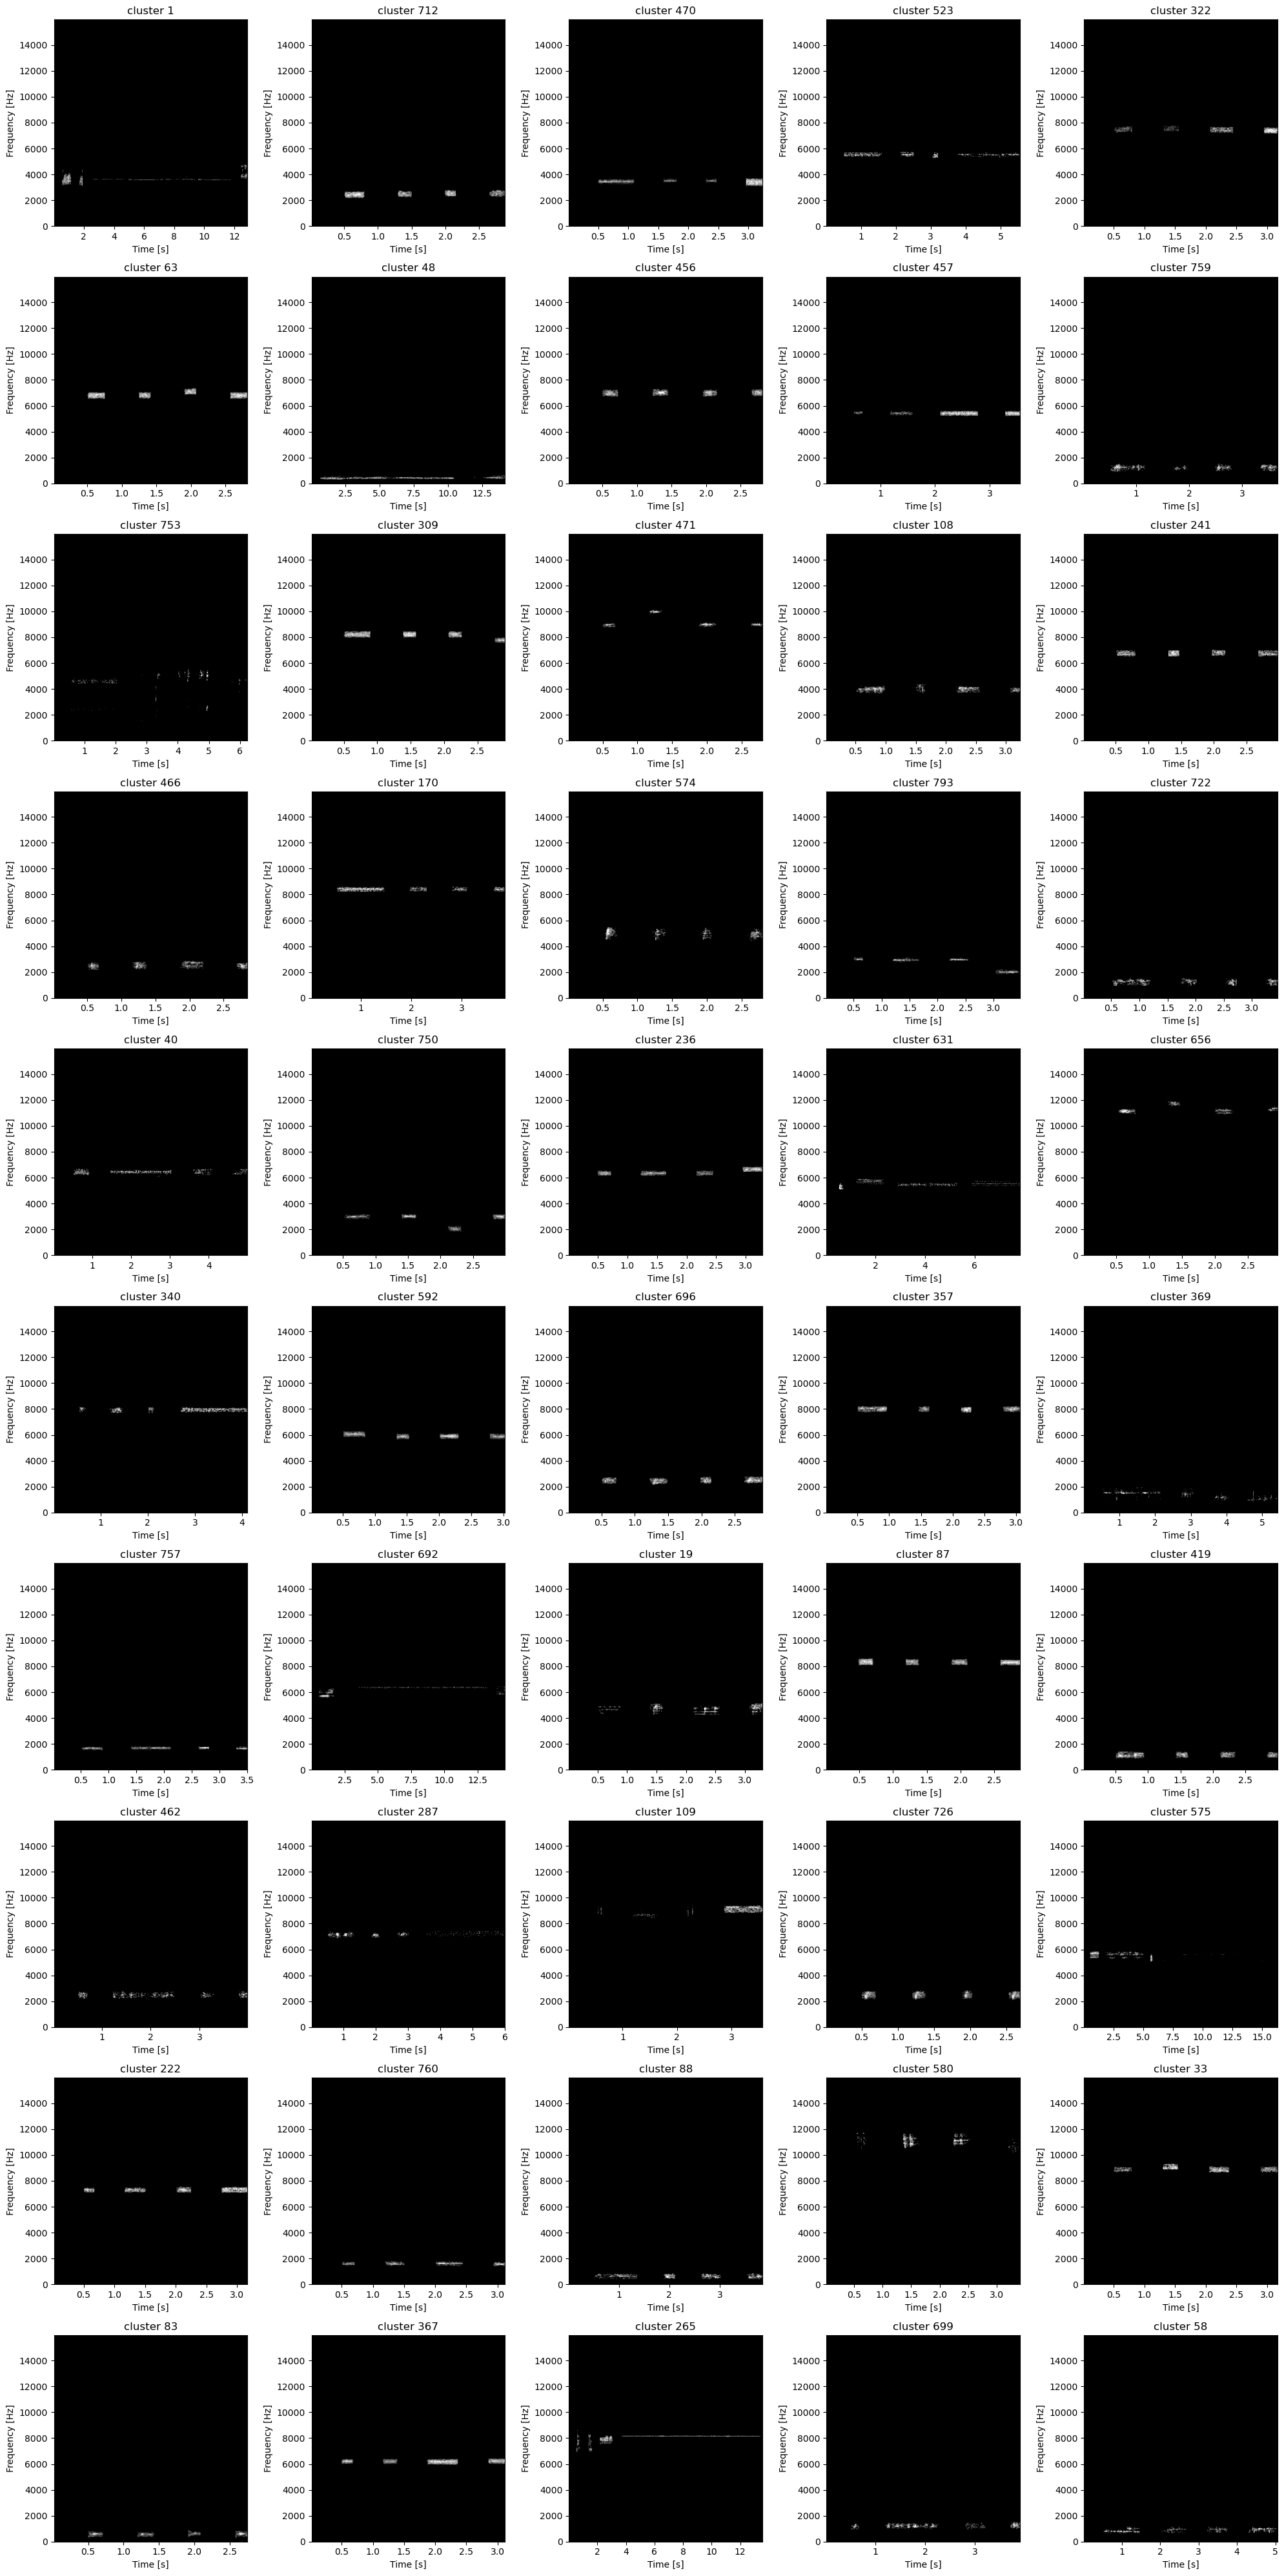

In [ ]:
from maad.util.visualization import plot_spectrogram
import matplotlib.pyplot as plt
from math import ceil
from scipy import signal
from tqdm import tqdm

# Create vignettes with the most representative ROIs for each cluster
#----------------------------------------------------------------------

# get the cluster number list from the biggest cluster to the smallest
cluster_number_list = CLUSTER_NUM_ASC_ORDER[0:50]

# prepare the grid
columns = 5
rows = ceil(len(cluster_number_list) / columns)
fig, axes = plt.subplots(rows, columns, figsize = (20,20/5*rows))

# Max number of samples by cluster
NUM_SAMPLES = 4

# initialize the counter
ii = 0

# 1. zero padding
#-----------------------------------------------------------------------
# get the fs
_, fs = maad.sound.load(df_cluster_selected.fullfilename_ts.values[0])

# create the vector of zero padding
duration = 0.5 # in seconds
sig0 = [0] * int(fs*duration)

# 2. load 5 audio for each cluster and concatenate them into a single audio
#-----------------------------------------------------------------------

for num in tqdm(cluster_number_list):

    sub_df = df_cluster_selected[df_cluster_selected['cluster_number'] == num]

    # Sort the dataframe by the value of the metric
    sub_df = sub_df.sort_values(by=METRIC)

    # Sample the rows. Get a maximum of NUM_SAMPLES rows. 
    # Could be less if the dataframe as less rows
    try :
        sub_df = sub_df.iloc[0:NUM_SAMPLES]
    except:
        print("less samples than the number required N={}".format(NUM_SAMPLES))

    # initialize an empty list
    sig = []

    for _ , row in sub_df.iterrows() :

        sig1, fs = maad.sound.load(row.fullfilename_ts)
        window = signal.windows.tukey(len(sig1), alpha=0.05)
        sig1 = (sig1 * window).tolist()

        # merge all sig with zero padding in between
        sig  += sig0 + sig1
    
    # list to array
    sig = np.asarray(sig)
    
    # Compute the spectrogram of the concatenate audio
    Sxx, tn, fn, ext = maad.sound.spectrogram(sig, fs, nperseg=1024)

    # Convert into dB from 0dB to 96dB maximum
    Sxx_dB = maad.util.power2dB(Sxx, db_range=96) + 96

    # Plot the spectrogram in the right subplot
    rr = ii // columns
    cc = ii - rr * columns
    maad.util.plot_spectrogram(Sxx_dB, extent=ext, 
                                # db_range=30, 
                                # gain=20, 
                                log_scale = False,
                                now = False,
                                title = 'cluster ' + str(num),
                                colorbar=False, ax=axes[rr, cc],
                                vmin=np.percentile(Sxx_dB,99), vmax=np.percentile(Sxx_dB,99.99))

    ii = ii +1

# 3. Save figure
#-----------------------------------------------------------------------
filename = str(DATASET_NAME) + '.pdf'
plt.savefig(SAVE_PATH /filename)
filename = str(DATASET_NAME) + '.png'
plt.savefig(SAVE_PATH /filename)

# Display
plt.show()